# Load the model

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as functional

In [2]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [3]:
unet_model = UNet(n_channels=1, n_classes=1).float()
unet_model.load_state_dict(torch.load("model_cifar.pt"))

<All keys matched successfully>

# Semantic segmentation

1. get the region of the interest
   - How to determine the uplimit?
   - How to determine the downlimit?
2. Divide the region of the interest into 256x256 patches
   - let's just get the largest 256 multiple that is smaller than image size.
3. Apply deep learning model to each batches

However, I have a second idea. The disadvantage of the plan above is that it might break the same breaking event. 
1. get the region of the interest
2. resize it into 256x256 or some other possible sizes
3. Apply deep learning model to the image.

An update about the previous idea:
Just input any size of images, there is a transform process in dataloader so the input and the ouput will be in the same size but inside the model process the code make them into 256x256. 
The performance of the model is still awesome. 

## Horizon Tracking

In [4]:
import numpy as np
import cv2

In [5]:
def Image2World(u,v,H,roll,pitch,yaw,IntrinsicMatrix):
    """_summary_

    Args:
        u (int): location at the x axis in image coordinate
        v (int): location at the y axis in image coordinate
        H (float): camera height above mean water level
        roll (float): change of the angle of camera around the y axis
        pitch (float): change of the angle of camera around the x axis
        yaw (float): change of the angle of cameraaround the z axis
        IntrinsicMatrix (ndarray): intrinsic matrix of the camera

    The definition is according to the paper:
    Schwendeman, M., & Thomson, J. (2015). 
    A horizon-tracking method for shipboard video stabilization and rectification.
    Journal of Atmospheric and Oceanic Technology, 32(1), 164-176.
    Returns:
        x (float): corresponding x location in real-world coordinate. Unit is m.
        y (float): corresponding y location in real-world coordinate. Unit is m.
        
    """
    R_roll = np.array([[np.cos(roll), -np.sin(roll), 0],
                       [np.sin(roll), np.cos(roll), 0], 
                       [0, 0, 1]])
    R_pitch = np.array([[1, 0, 0], 
                        [0, -np.cos(pitch), -np.sin(pitch)], 
                        [0, np.sin(pitch), -np.cos(pitch)]])
    R_yaw = np.array([[np.cos(yaw), 0, -np.sin(yaw)],
                      [0, 1, 0], 
                      [np.sin(yaw), 0, np.cos(yaw)]])

    R = R_yaw.dot(R_roll.dot(R_pitch))
    # 矩阵求逆
    UV0 = np.array([u, v])
    one = np.ones(u.shape[0])
    UV1 = np.r_[UV0, np.array([one])]
    UV = np.r_[UV1, np.array([one])]

    zero = np.zeros(R.shape[0])
    r = np.c_[R, zero.T]
    rr = np.r_[r, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    a = np.linalg.inv(KK.dot(rr)).dot(UV)

    x = -np.divide(a[0, :], a[2, :]) * H
    y = -np.divide(a[1, :], a[2, :]) * H

    return (x, y)

def Image2Image(u1,v1,roll1,pitch1,yaw1,roll2,pitch2,yaw2,IntrinsicMatrix):
    """_summary_

    Args:
        u1 (_type_): _description_
        v1 (_type_): _description_
        roll1 (_type_): _description_
        pitch1 (_type_): _description_
        yaw1 (_type_): _description_
        roll2 (_type_): _description_
        pitch2 (_type_): _description_
        yaw2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], 
                        [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch1), -np.sin(pitch1)], 
                         [0, np.sin(pitch1), -np.cos(pitch1)]])
    R_yaw1 = np.array([[np.cos(yaw1), 0, -np.sin(yaw1)],
                       [0, 1, 0], 
                       [np.sin(yaw1), 0, np.cos(yaw1)]])
    R1 = R_yaw1.dot(R_roll1.dot(R_pitch1))

    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch2), -np.sin(pitch2)], 
                         [0, np.sin(pitch2), -np.cos(pitch2)]])
    R_yaw2 = np.array([[np.cos(yaw2), 0, -np.sin(yaw2)],
                       [0, 1, 0], 
                       [np.sin(yaw2), 0, np.cos(yaw2)]])
    R2 = R_yaw2.dot(R_roll2.dot(R_pitch2))

    UV0 = np.array([u1, v1])
    one = np.ones(u1.shape[0])
    UV = np.r_[UV0, np.array([one])]
    UV1 = np.r_[UV, np.array([one])]

    zero = np.zeros(R1.shape[0])
    r1 = np.c_[R1, zero.T]
    rr1 = np.r_[r1, np.array([np.append(zero, 1)])]

    zero = np.zeros(R2.shape[0])
    r2 = np.c_[R2, zero.T]
    rr2 = np.r_[r2, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    UV2 = (KK.dot(rr2)).dot(np.linalg.inv(KK.dot(rr1)).dot(UV1))

    u2 = np.divide(UV2[0, :], UV2[2, :])
    v2 = np.divide(UV2[1, :], UV2[2, :])

    return (u2, v2)

def Angle2Line(inc,roll,IntrinsicMatrix):
    """_summary_

    Args:
        inc (_type_): _description_
        roll (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    theta = np.arctan(-fu / (fv * np.tan(roll)))
    rho = ((fu * np.sin(roll) * np.cos(theta) - fv * np.cos(roll) *
           np.sin(theta)) / np.tan(inc) 
           + cu * np.cos(theta) + cv * np.sin(theta))
    return (theta, rho)


def Line2Angle(theta,rho,IntrinsicMatrix):
    """_summary_

    Args:
        theta (_type_): _description_
        rho (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    roll = np.arctan(-fu / (fv * np.tan(theta)))
    inc = np.arctan((fu * np.sin(roll) * np.cos(theta) 
                     - fv * np.cos(roll) * np.sin(theta)) / 
                    (rho - cu * np.cos(theta) - cv * np.sin(theta)))
    if inc <= 0:
        inc = np.pi + inc

    return (inc, roll)



def Horizon_tracking(img):
    """This function is used to track the horizon.

    Args:
        img (ndarray): input image

    Returns:
        horizonPixel: the location of pixels for horizon
        rho: intercept of the line standing for horizon
        theta: slope of the line standing for horizon
    """
    # sharpen the image to make the horizon more clear
    sharpen_kernel = np.array(
        [[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
    sharpen_image = cv2.filter2D(img, cv2.CV_32F, sharpen_kernel)
    
    # cv2.convertScaleAbs help separate foreground and background
    sharpen_image = cv2.convertScaleAbs(sharpen_image)
    gray = cv2.cvtColor(sharpen_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # dilate the gray image to get rid of the noise 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # substruct the images with different dilation degree to get the horizon
    sure_bg = cv2.dilate(closing, kernel, iterations=50)
    sure_fg = cv2.dilate(closing, kernel, iterations=49)
    horizon = cv2.subtract(sure_bg, sure_fg)
    
    # use canny algorithm to track the contour profile again
    dst = cv2.Canny(horizon, 100, 255, None, 3)
    # use Hough algorithm to track the line
    lines = cv2.HoughLines(dst, 0.8, np.pi / 180, 200)
    
    # draw the line standing for horizon 
    # TODO(Xin, 2022/6/25): Can make some improvement here
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        rho = rho + 50
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 10000 * (-b))
        y1 = int(y0 + 10000 * (a))
        x2 = int(x0 - 10000 * (-b))
        y2 = int(y0 - 10000 * (a))
        blackboard = np.zeros([1080, 1920])
        horizon_line = cv2.line(blackboard, (x1, y1), (x2, y2), 255, 1)
    horizonPixel = np.argwhere(horizon_line == 255)
    return (horizonPixel, rho, theta)

def StabImage(img,inc1,roll1,azi1,inc2,roll2,azi2,IntrinsicMatrix):
    """_summary_

    Args:
        img (_type_): _description_
        inc1 (_type_): _description_
        roll1 (_type_): _description_
        azi1 (_type_): _description_
        inc2 (_type_): _description_
        roll2 (_type_): _description_
        azi2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """

    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
         [0, -np.cos(inc1), -np.sin(inc1)], 
         [0, np.sin(inc1), -np.cos(inc1)]])
    R_azi1 = np.array([[np.cos(azi1), 0, -np.sin(azi1)],
                       [0, 1, 0], 
                       [np.sin(azi1), 0, np.cos(azi1)]])
    R1 = R_azi1.dot(R_roll1.dot(R_pitch1))
    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(inc2), -np.sin(inc2)], 
                         [0, np.sin(inc2), -np.cos(inc2)]])
    R_azi2 = np.array([[np.cos(azi2), 0, -np.sin(azi2)],
                       [0, 1, 0], [np.sin(azi2), 0, np.cos(azi2)]])
    R2 = R_azi2.dot(R_roll2.dot(R_pitch2))
    R = IntrinsicMatrix.dot(R2).dot(np.linalg.inv(IntrinsicMatrix.dot(R1)))

    stabFrame = cv2.warpPerspective(
        img, R, (np.shape(img)[1], np.shape(img)[0]))

    return (R, stabFrame)

### Check the code

In [6]:
# read in the image
img = cv2.imread("E:/GoPro_deep/image/GH010005.MP4/original_frame1.jpg")

# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  

# size of the image
nv = np.shape(img)[0]
nu = np.shape(img)[1]

# get the horizon when the camera is stable
(thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)

# pay attention to the theta here, get the horizon at any posture
(line, rho, theta) = Horizon_tracking(img)

# get the camera angles at any posture
(inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
azi = 0

# stable the image, the horizon will be parallel with the u axis
(R, stabFrame) = StabImage(img, inc, roll, azi,
                                   incStab, rollStab, aziStab, IntrinsicMatrix)

# try to get the top view
uplimit = int((1080 - max(line[:, 0]))/4 + max(line[:, 0]))
bottomlimit = 900
uPoint_init = np.array([0, 0, 1920, 1920])
vPoint_init = np.array([uplimit, bottomlimit, bottomlimit, uplimit])

(uPoint0, vPoint0) = Image2Image(uPoint_init, vPoint_init,
                                    roll, inc, azi, rollStab,
                                    incStab, aziStab, IntrinsicMatrix)
uPoint = np.round(uPoint0 - min(uPoint0))
vPoint = np.round(vPoint0 - min(vPoint0))

uPoint_ori = uPoint_init - min(uPoint_init)
vPoint_ori = vPoint_init - min(vPoint_init)


(xPoint0, yPoint0) = Image2World(uPoint_init,vPoint_init, H,
                                 roll, inc, azi, IntrinsicMatrix)
xPoint = xPoint0 - min(xPoint0)
yPoint = -yPoint0 + max(yPoint0)
xPoint = np.round(xPoint) * 10
yPoint = np.round(yPoint) * 10


pts0 = np.float32([[uPoint_ori[0], vPoint_ori[0]], [uPoint_ori[1], vPoint_ori[1]],
                   [uPoint_ori[2], vPoint_ori[2]], [uPoint_ori[3], vPoint_ori[3]]])
pts1 = np.float32([[uPoint[0], vPoint[0]], [uPoint[1], vPoint[1]], 
                   [uPoint[2], vPoint[2]], [uPoint[3], vPoint[3]]])
pts2 = np.float32([[xPoint[0], yPoint[0]], [xPoint[1], yPoint[1]], 
                   [xPoint[2], yPoint[2]], [xPoint[3], yPoint[3]]])

# image size of the top view image
xlimit = int(max(xPoint) - min(xPoint))
ylimit = int(max(yPoint) - min(yPoint))
# image size of the stable image
ulimit_stable = int(max(uPoint) - min(uPoint))
vlimit_Stable = int(max(vPoint) - min(vPoint))

# get the corresponding ROI in the stabilized frames
M1 = cv2.getPerspectiveTransform(pts0, pts1)
a1 = img[uplimit:bottomlimit, 0:1920]
dst1 = cv2.warpPerspective(a1,M1,(ulimit_stable, vlimit_Stable))
# get the rectified ROI
M2 = cv2.getPerspectiveTransform(pts1, pts2)
a2 = dst1
dst2 = cv2.warpPerspective(a2,M2,(xlimit, ylimit))

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_20112\3727979405.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


In [7]:
print(pts0)
print("#"*100)
print(pts1)
print("#"*100)
print(pts2)

[[   0.    0.]
 [   0.  431.]
 [1920.  431.]
 [1920.    0.]]
####################################################################################################
[[   0.    0.]
 [   5.  429.]
 [1894.  526.]
 [1931.  102.]]
####################################################################################################
[[  0.   0.]
 [290. 350.]
 [500. 370.]
 [620. 170.]]


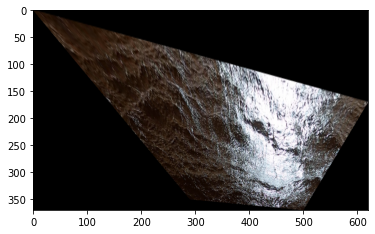

In [8]:
import matplotlib.pyplot as plt
plt.imshow(dst2)

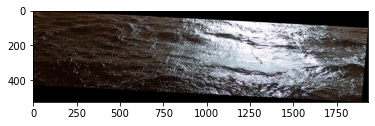

In [9]:
plt.imshow(dst1)

In [10]:
np.shape(img)[0]

1080

In [11]:
line

array([[ 165, 1910],
       [ 165, 1911],
       [ 165, 1912],
       ...,
       [ 266,    7],
       [ 266,    8],
       [ 266,    9]], dtype=int64)

### Rectification function

In [12]:
def rectify(img,IntrinsicMatrix,H,incStab,
            rollStab,aziStab,line,rho,theta,roi):
    
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    # get the horizon when the camera is stable
    (thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)


    # get the camera angles at any posture
    (inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
    azi = 0

    # stable the image, the horizon will be parallel with the u axis
    (R, stabFrame) = StabImage(img, inc, roll, azi,
                                    incStab, rollStab, aziStab, IntrinsicMatrix)

    # try to get the top view
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)

    uPoint_init = np.array([0, 0, 1920, 1920])
    vPoint_init = np.array([uplimit, bottomlimit, bottomlimit, uplimit])

    (uPoint0, vPoint0) = Image2Image(uPoint_init, vPoint_init,
                                        roll, inc, azi, rollStab,
                                        incStab, aziStab, IntrinsicMatrix)
    uPoint = np.round(uPoint0 - min(uPoint0))
    vPoint = np.round(vPoint0 - min(vPoint0))

    uPoint_ori = uPoint_init - min(uPoint_init)
    vPoint_ori = vPoint_init - min(vPoint_init)


    (xPoint0, yPoint0) = Image2World(uPoint_init,vPoint_init, H,
                                    roll, inc, azi, IntrinsicMatrix)
    xPoint = xPoint0 - min(xPoint0)
    yPoint = -yPoint0 + max(yPoint0)
    xPoint = np.round(xPoint) * 10
    yPoint = np.round(yPoint) * 10


    pts0 = np.float32([[uPoint_ori[0], vPoint_ori[0]], [uPoint_ori[1], vPoint_ori[1]],
                    [uPoint_ori[2], vPoint_ori[2]], [uPoint_ori[3], vPoint_ori[3]]])
    pts1 = np.float32([[uPoint[0], vPoint[0]], [uPoint[1], vPoint[1]], 
                    [uPoint[2], vPoint[2]], [uPoint[3], vPoint[3]]])
    pts2 = np.float32([[xPoint[0], yPoint[0]], [xPoint[1], yPoint[1]], 
                    [xPoint[2], yPoint[2]], [xPoint[3], yPoint[3]]])

    # image size of the top view image
    xlimit = int(max(xPoint) - min(xPoint))
    ylimit = int(max(yPoint) - min(yPoint))
    # image size of the stable image
    ulimit_stable = int(max(uPoint) - min(uPoint))
    vlimit_Stable = int(max(vPoint) - min(vPoint))

    # get the corresponding ROI in the stabilized frames
    M1 = cv2.getPerspectiveTransform(pts0, pts1)
    a1 = roi 
    # TODO: I need to make this function simpler and better
    dst1 = cv2.warpPerspective(a1,M1,(ulimit_stable, vlimit_Stable))
    # get the rectified ROI
    M2 = cv2.getPerspectiveTransform(pts1, pts2)
    a2 = dst1
    dst2 = cv2.warpPerspective(a2,M2,(xlimit, ylimit))
    return dst2

In [13]:
img = cv2.imread("E:/GoPro_1Hz/2020_3_4_GoPro/image_left/GH010004.MP4/original_frame150.jpg")

# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  
(line, rho, theta) = Horizon_tracking(img)


test = rectify(img,IntrinsicMatrix,H,incStab,rollStab,aziStab,line,rho,theta,output)

NameError: name 'output' is not defined

In [14]:
plt.imshow(test)

NameError: name 'test' is not defined

## Determine the ROI

In [15]:
def get_ROI(img):
    """_summary_

    Args:
        img (_type_): _description_
    """
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    
    # detect the horizon in the image
    (line, rho, theta) = Horizon_tracking(img)
    
    # determine the region of interest according to the horizon
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)
    
    return uplimit, bottomlimit, line

### Check the code

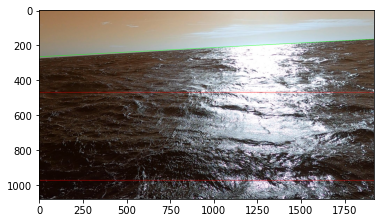

In [16]:
# read in the image
img = cv2.imread("E:/GoPro_deep/image/GH010005.MP4/original_frame1.jpg")
aaa, bbb, ccc = get_ROI(img)
img[aaa, :] = [255, 0, 0]
img[aaa+1, :] = [255, 0, 0]
img[bbb, :] = [255, 0, 0]
img[bbb+1, :] = [255, 0, 0]
img[ccc[:, 0], ccc[:, 1]] = [0, 255, 0]
img[ccc[:, 0]+1, ccc[:, 1]] = [0, 255, 0]
plt.imshow(img)

## Apply Unet Model

### Unify the filename

In [17]:
# TODO: Make a code to rename all file

### Segementation and rectification

In [18]:
import os

store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

# get the name of the folders that store one of these cameras
camera_folder = os.listdir(os.path.join(store_path, date_folder[0]))

# get the name of the folders that store images of these videos
video_path = os.path.join(store_path, date_folder[0], camera_folder[0])
video_folder = os.listdir(video_path)
# get the name of each image
image_path = os.path.join(video_path, video_folder[0])
image_file = os.listdir(image_path)
image_file.sort(key=lambda x:int(x[14:-4]))

In [19]:
image_file

['original_frame1.jpg',
 'original_frame2.jpg',
 'original_frame3.jpg',
 'original_frame4.jpg',
 'original_frame5.jpg',
 'original_frame6.jpg',
 'original_frame7.jpg',
 'original_frame8.jpg',
 'original_frame9.jpg',
 'original_frame10.jpg',
 'original_frame11.jpg',
 'original_frame12.jpg',
 'original_frame13.jpg',
 'original_frame14.jpg',
 'original_frame15.jpg',
 'original_frame16.jpg',
 'original_frame17.jpg',
 'original_frame18.jpg',
 'original_frame19.jpg',
 'original_frame20.jpg',
 'original_frame21.jpg',
 'original_frame22.jpg',
 'original_frame23.jpg',
 'original_frame24.jpg',
 'original_frame25.jpg',
 'original_frame26.jpg',
 'original_frame27.jpg',
 'original_frame28.jpg',
 'original_frame29.jpg',
 'original_frame30.jpg',
 'original_frame31.jpg',
 'original_frame32.jpg',
 'original_frame33.jpg',
 'original_frame34.jpg',
 'original_frame35.jpg',
 'original_frame36.jpg',
 'original_frame37.jpg',
 'original_frame38.jpg',
 'original_frame39.jpg',
 'original_frame40.jpg',
 'origina

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### No loop

In [21]:
img = cv2.imread("E:/GoPro_1Hz/2020_3_4_GoPro/image_left/GH010004.MP4/original_frame150.jpg")
roi_up, roi_bottom, horizon = get_ROI(img)
(line, rho, theta) = Horizon_tracking(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_roi = img[roi_up: roi_bottom+1, 0:1920]
img_roi_tensor = torch.from_numpy(img_roi / 255).float()
img_roi_tensor = img_roi_tensor.unsqueeze(0)
img_roi_tensor = img_roi_tensor.unsqueeze(0)
unet_model.to(device)
img_roi_tensor = img_roi_tensor.to(device)

with torch.no_grad():
    output = unet_model(img_roi_tensor)
output = output.squeeze(0)
output = output.squeeze(0)

# assign all large than 0.8 as 1 and less as 0
output = output.cpu().numpy()

output[output >= 0.8] = 1
output[output < 0.8] = 0

output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                           aziStab,line,rho,theta,output)

img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                      aziStab,line,rho,theta,img_roi)
area = img_roi_rec[img_roi_rec>0].size
active_whitecaps = np.argwhere(output_rectified>0)
active_whitecaps_area = output_rectified[output_rectified>0].size
active_whitecaps_fraction = active_whitecaps_area / area

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_8216\3727979405.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


In [22]:
active_whitecaps_fraction

0.0026939843678933043

In [23]:
aaa = rectify(img,IntrinsicMatrix,H,incStab,rollStab,aziStab,line,rho,theta,img_roi)

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_8216\3727979405.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


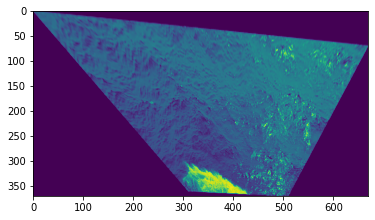

In [24]:
plt.imshow(aaa)

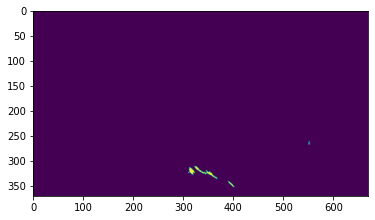

In [25]:
plt.imshow(output_rectified)

### Loop

In [26]:
import pandas as pd
result = pd.DataFrame(columns=('date','camera','video','image_fname',
                               'active_whitecaps','active_whitecaps_fraction',
                               'predict_image'))

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [74]:
for fname in image_file:
    
    path = os.path.join(image_path, fname)
    img = cv2.imread(path)
    roi_up, roi_bottom, horizon = get_ROI(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_roi = img[roi_up: roi_bottom+1, 0:1920]
    img_roi_tensor = torch.from_numpy(img_roi / 255).float()
    img_roi_tensor = img_roi_tensor.unsqueeze(0)
    img_roi_tensor = img_roi_tensor.unsqueeze(0)
    unet_model.to(device)
    img_roi_tensor = img_roi_tensor.to(device)
    
    with torch.no_grad():
        output = unet_model(img_roi_tensor)
    output = output.squeeze(0)
    output = output.squeeze(0)
    
    # assign all large than 0.8 as 1 and less as 0
    output = output.cpu().numpy()

    output[output >= 0.8] = 1
    output[output < 0.8] = 0

    output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
    output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                            aziStab,line,rho,theta,output)

    img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                        aziStab,line,rho,theta,img_roi)
    area = img_roi_rec[img_roi_rec>0].size
    active_whitecaps = np.argwhere(output_rectified>0)
    active_whitecaps_area = output_rectified[output_rectified>0].size
    active_whitecaps_fraction = active_whitecaps_area / area
    result = result.append(pd.DataFrame({
        'date':[date_folder[0]],
        'camera':[camera_folder[0]],
        'video':[video_folder[0]],
        'image_fname':[fname],
        'active_whitecaps':[active_whitecaps],
        'active_whitecaps_fraction':[active_whitecaps_fraction],
        'predict_image':[output]
    }))

In [75]:
result

,date,camera,video,image_fname,active_whitecaps,active_whitecaps_fraction,predict_image
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame1.jpg,"[[240, 426], [241, 426], [242, 426], [299, 417...",0.000253,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame2.jpg,"[[300, 502], [330, 393], [331, 393], [331, 402...",0.000275,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame3.jpg,"[[229, 359], [230, 359], [231, 359], [232, 359...",0.001211,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame4.jpg,"[[210, 581], [210, 582], [211, 581], [211, 582...",0.000552,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame5.jpg,"[[258, 545], [258, 546], [259, 544], [259, 545...",0.000865,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame527.jpg,"[[165, 290], [165, 291], [165, 292], [166, 290...",0.000725,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame528.jpg,"[[299, 325], [300, 325], [300, 326], [301, 326...",0.001066,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame529.jpg,"[[278, 285], [278, 286], [279, 285], [279, 286...",0.002619,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame530.jpg,"[[258, 485], [259, 484], [259, 485], [260, 484...",0.000181,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [78]:
result['active_whitecaps_fraction'].values.astype(float)

array([2.53269641e-04, 2.74634349e-04, 1.21111990e-03, 5.51995919e-04,
       8.65208836e-04, 3.55745286e-04, 9.90651598e-04, 2.94633070e-03,
       1.23880179e-03, 5.12212407e-04, 2.22421802e-03, 5.62995700e-04,
       6.09939917e-04, 5.08976817e-04, 2.29559441e-03, 2.37165179e-04,
       3.78891532e-04, 1.40877810e-04, 1.68695701e-04, 2.46981147e-03,
       2.54001221e-03, 6.63505123e-04, 3.97317757e-04, 1.98855708e-03,
       1.54604918e-03, 4.13046674e-04, 5.52509372e-04, 2.52943437e-03,
       4.53977189e-04, 5.39820527e-04, 6.52759841e-04, 4.61586880e-04,
       8.38328373e-05, 1.00061576e-03, 1.18808837e-04, 3.97375925e-04,
       1.01146090e-03, 8.10180335e-04, 2.09816620e-04, 1.02357733e-03,
       1.79611006e-03, 7.53779366e-04, 3.69469289e-04, 4.60209326e-04,
       2.78399933e-03, 1.77181283e-03, 4.82689631e-04, 3.34914876e-04,
       2.12240111e-03, 5.51753038e-04, 3.00321274e-04, 6.62838484e-04,
       4.89705687e-04, 7.83885553e-04, 8.86277356e-04, 2.93744157e-03,
      

In [84]:
result = result.reset_index(drop=True)

In [85]:
result.to_csv("E:/GoPro_1Hz_Unet_output/test_2022_6_26.csv")

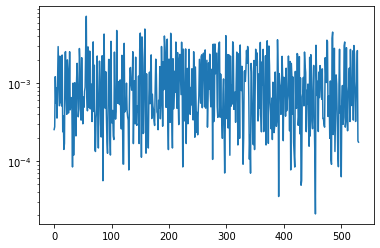

In [79]:
plt.semilogy(np.arange(531), result['active_whitecaps_fraction'].values.astype(float))

### Loop for a day and a camera

In [21]:
import os

store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

# get the name of the folders that store one of these cameras
camera_folder = os.listdir(os.path.join(store_path, date_folder[0]))

# get the name of the folders that store images of these videos
video_path = os.path.join(store_path, date_folder[0], camera_folder[0])
video_folder = os.listdir(video_path)
# get the name of each image
image_path = os.path.join(video_path, video_folder[0])
image_file = os.listdir(image_path)
image_file.sort(key=lambda x:int(x[14:-4]))

In [22]:
date_folder

['2020_3_4_GoPro', '2020_3_5_GoPro', '2020_3_6_GoPro', '2020_3_7_GoPro']

In [25]:
for i in range(1,3):
    print(i)

1
2


In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
import os
import pandas as pd

store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

for i in range(1,3):
    # get the name of the folders that store one of these cameras
    camera_folder = os.listdir(os.path.join(store_path, date_folder[i+1]))

    for camera_i in camera_folder:
        video_path = os.path.join(store_path, date_folder[i+1], camera_i)
        video_folder = os.listdir(video_path)
        for video_id in video_folder:
            image_path = os.path.join(video_path, video_id)
            image_file = os.listdir(image_path)
            result = pd.DataFrame(columns=('date','camera','video','image_fname',
                                'active_whitecaps','active_whitecaps_fraction',
                                'predict_image'))

            for fname in image_file[:]:
                if fname[0:2] =='._':
                    os.remove(os.path.join(image_path, fname))
                    image_file.remove(fname)
                    
            image_file.sort(key=lambda x:int(x[14:-4]))
            

            print(f'The code is working on {date_folder[i+1]}-{camera_i}-{video_id}!!!')
            for fname in image_file:

                path = os.path.join(image_path, fname)
                img = cv2.imread(path)
                
                try:
                    roi_up, roi_bottom, horizon = get_ROI(img)
                except:
                    result = result.append(pd.DataFrame({
                    'date':[date_folder[i+1]],
                    'camera':[camera_i],
                    'video':[video_id],
                    'image_fname':[fname],
                    'active_whitecaps':[0],
                    'active_whitecaps_fraction':[0],
                    'predict_image':[0]
                    }))
                else:
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    img_roi = img[roi_up: roi_bottom+1, 0:1920]
                    img_roi_tensor = torch.from_numpy(img_roi / 255).float()
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    unet_model.to(device)
                    img_roi_tensor = img_roi_tensor.to(device)
                    
                    with torch.no_grad():
                        output = unet_model(img_roi_tensor)
                    output = output.squeeze(0)
                    output = output.squeeze(0)
                    
                    # assign all large than 0.8 as 1 and less as 0
                    output = output.cpu().numpy()
                    output[output >= 0.8] = 1
                    output[output < 0.8] = 0

                    output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
                    output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                            aziStab,line,rho,theta,output)

                    img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                        aziStab,line,rho,theta,img_roi)
                    area = img_roi_rec[img_roi_rec>0].size
                    active_whitecaps = np.argwhere(output_rectified>0)
                    active_whitecaps_area = output_rectified[output_rectified>0].size
                    active_whitecaps_fraction = active_whitecaps_area / area
                    result = result.append(pd.DataFrame({
                        'date':[date_folder[i+1]],
                        'camera':[camera_i],
                        'video':[video_id],
                        'image_fname':[fname],
                        'active_whitecaps':[active_whitecaps],
                        'active_whitecaps_fraction':[active_whitecaps_fraction],
                        'predict_image':[output]
                    }))
                result = result.reset_index(drop=True)
                if not os.path.exists(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}"):
                    os.makedirs(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}")
                result.to_csv(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}/{video_id[0:-4]}_active.csv")
                

The code is working on 2020_3_6_GoPro-image_left-GH010044.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH010045.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH010046.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH010047.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH010048.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH010049.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH020044.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH020045.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH020046.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH020047.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH020048.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH020049.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH030044.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH030045.MP4!!!
The code is working on 2020_3_6_GoPro-image_left-GH030046.MP4!!!
The code is working on 20

# Loop for everythin

In [34]:
date_folder

['2020_3_4_GoPro', '2020_3_5_GoPro', '2020_3_6_GoPro', '2020_3_7_GoPro']

In [35]:
if not os.path.exists(f"E:/GoPro_1Hz_Unet_output/{date_folder[1]}"):
                os.makedirs(f"E:/GoPro_1Hz_Unet_output/{date_folder[1]}")

In [56]:
import os

store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

for i in range(3):
    # get the name of the folders that store one of these cameras
    camera_folder = os.listdir(os.path.join(store_path, date_folder[i+1]))

    for camera_i in camera_folder:
        video_path = os.path.join(store_path, date_folder[i+1], camera_i)
        video_folder = os.listdir(video_path)
        for video_id in video_folder:
            image_path = os.path.join(video_path, video_id)
            image_file = os.listdir(image_path)
            result = pd.DataFrame(columns=('date','camera','video','image_fname',
                                'active_whitecaps','active_whitecaps_fraction',
                                'predict_image'))

            for fname in image_file[:]:
                if fname[0:2] =='._':
                    os.remove(os.path.join(image_path, fname))
                    image_file.remove(fname)
                    
            image_file.sort(key=lambda x:int(x[14:-4]))
            

            print(f'The code is working on {date_folder[i+1]}-{camera_i}-{video_id}!!!')
            for fname in image_file:

                path = os.path.join(image_path, fname)
                img = cv2.imread(path)
                
                try:
                    roi_up, roi_bottom, horizon = get_ROI(img)
                except:
                    result = result.append(pd.DataFrame({
                    'date':[date_folder[i+1]],
                    'camera':[camera_i],
                    'video':[video_id],
                    'image_fname':[fname],
                    'active_whitecaps':[0],
                    'active_whitecaps_fraction':[0],
                    'predict_image':[0]
                    }))
                else:
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    img_roi = img[roi_up: roi_bottom+1, 0:1920]
                    img_roi_tensor = torch.from_numpy(img_roi / 255).float()
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    unet_model.to(device)
                    img_roi_tensor = img_roi_tensor.to(device)
                    
                    with torch.no_grad():
                        output = unet_model(img_roi_tensor)
                    output = output.squeeze(0)
                    output = output.squeeze(0)
                    
                    # assign all large than 0.8 as 1 and less as 0
                    output = output.cpu().numpy()
                    output[output >= 0.8] = 1
                    output[output < 0.8] = 0

                    output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
                    output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                            aziStab,line,rho,theta,output)

                    img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                        aziStab,line,rho,theta,img_roi)
                    area = img_roi_rec[img_roi_rec>0].size
                    active_whitecaps = np.argwhere(output_rectified>0)
                    active_whitecaps_area = output_rectified[output_rectified>0].size
                    active_whitecaps_fraction = active_whitecaps_area / area
                    result = result.append(pd.DataFrame({
                        'date':[date_folder[i+1]],
                        'camera':[camera_i],
                        'video':[video_id],
                        'image_fname':[fname],
                        'active_whitecaps':[active_whitecaps],
                        'active_whitecaps_fraction':[active_whitecaps_fraction],
                        'predict_image':[output]
                    }))
                result = result.reset_index(drop=True)
                if not os.path.exists(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}"):
                    os.makedirs(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}")
                result.to_csv(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}/{video_id[0:-4]}_active.csv")
                

The code is working on 2020_3_5_GoPro-image_left-GH010007.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH010008.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH010009.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH010010.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH010011.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH010042.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH010043.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH020007.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH020008.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH020009.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH020010.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH020011.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH020042.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH020043.MP4!!!
The code is working on 2020_3_5_GoPro-image_left-GH030007.MP4!!!
The code is working on 20

KeyboardInterrupt: 

In [50]:
fname

'original_frame325.jpg'

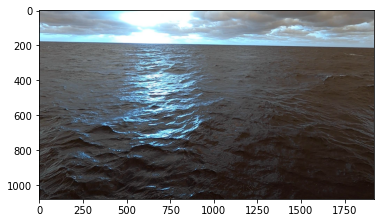

In [51]:
plt.imshow(img)

In [53]:
(line, rho, theta) = Horizon_tracking(img)

TypeError: 'NoneType' object is not subscriptable

In [40]:
video_id[0:-4]

'GH010007'

In [42]:
image_file

['original_frame1.jpg',
 'original_frame2.jpg',
 'original_frame3.jpg',
 'original_frame4.jpg',
 'original_frame5.jpg',
 'original_frame6.jpg',
 'original_frame7.jpg',
 'original_frame8.jpg',
 'original_frame9.jpg',
 'original_frame10.jpg',
 'original_frame11.jpg',
 'original_frame12.jpg',
 'original_frame13.jpg',
 'original_frame14.jpg',
 'original_frame15.jpg',
 'original_frame16.jpg',
 'original_frame17.jpg',
 'original_frame18.jpg',
 'original_frame19.jpg',
 'original_frame20.jpg',
 'original_frame21.jpg',
 'original_frame22.jpg',
 'original_frame23.jpg',
 'original_frame24.jpg',
 'original_frame25.jpg',
 'original_frame26.jpg',
 'original_frame27.jpg',
 'original_frame28.jpg',
 'original_frame29.jpg',
 'original_frame30.jpg',
 'original_frame31.jpg',
 'original_frame32.jpg',
 'original_frame33.jpg',
 'original_frame34.jpg',
 'original_frame35.jpg',
 'original_frame36.jpg',
 'original_frame37.jpg',
 'original_frame38.jpg',
 'original_frame39.jpg',
 'original_frame40.jpg',
 'origina

In [107]:
for fname in image_file:
        if fname[0:2] =='._':
            os.remove(os.path.join(image_path, fname))
            image_file.remove(fname)

In [105]:
image_file

['original_frame1.jpg',
 'original_frame10.jpg',
 'original_frame100.jpg',
 'original_frame101.jpg',
 'original_frame102.jpg',
 'original_frame103.jpg',
 'original_frame104.jpg',
 'original_frame105.jpg',
 'original_frame106.jpg',
 'original_frame107.jpg',
 'original_frame108.jpg',
 'original_frame109.jpg',
 'original_frame11.jpg',
 'original_frame110.jpg',
 'original_frame111.jpg',
 'original_frame112.jpg',
 'original_frame113.jpg',
 'original_frame114.jpg',
 'original_frame115.jpg',
 'original_frame116.jpg',
 'original_frame117.jpg',
 'original_frame118.jpg',
 'original_frame119.jpg',
 'original_frame12.jpg',
 'original_frame120.jpg',
 'original_frame121.jpg',
 'original_frame122.jpg',
 'original_frame123.jpg',
 'original_frame124.jpg',
 'original_frame125.jpg',
 'original_frame126.jpg',
 'original_frame127.jpg',
 'original_frame128.jpg',
 'original_frame129.jpg',
 'original_frame13.jpg',
 'original_frame130.jpg',
 'original_frame131.jpg',
 'original_frame132.jpg',
 'original_frame13

In [ ]:
# TODO: write a dataloader for image processing

# Write Everything as A file

1. including the information about horizon
2. including the location of active whitecap pixels
3. including the information of ROI both image coordinate and earth coordinate
4. including the active whitecap fraction
5. allow API to define different range of ROI to compare whether distance affect whitecap fraction and whether resolution affects whitecap fraction